#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [3]:
import numpy as np
from typing import List

def calculate_loss(X: np.ndarray, y: np.ndarray, w: np.ndarray, w0: float, gamma: float = 1.0, beta: float = 1.0) -> float:
    N = len(y)
    linear_model = X @ w + w0
    log_loss = np.mean(np.logaddexp(0, -y * linear_model))
    l1_regularization = gamma * np.sum(np.abs(w))
    l2_regularization = beta * np.sum(w**2)
    total_loss = log_loss + l1_regularization + l2_regularization
    return total_loss
X = np.random.randn(100, 5)
y = np.random.choice([-1, 1], 100)
w = np.random.randn(5)
w0 = 0.1
loss_value = calculate_loss(X, y, w, w0)
print(f"Значение функции потерь: {loss_value:.4f}")


Значение функции потерь: 20.7822


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [4]:

import numpy as np
from typing import List, Tuple
def compute_gradients(X: np.ndarray, y: np.ndarray, weights: List[float], bias: float, gamma=1.0, beta=1.0) -> Tuple[List[float], float]:
    num_samples, _ = X.shape
    weights = np.array(weights)
    linear_combination = np.dot(X, weights) + bias
    predictions = 1 / (1 + np.exp(-linear_combination))
    gradient_weights = (1 / num_samples) * np.dot(X.T, (predictions - y)) + gamma * np.sign(weights) + 2 * beta * weights
    gradient_bias = (1 / num_samples) * np.sum(predictions - y)
    return gradient_weights.tolist(), gradient_bias
np.random.seed(42)
X_random = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y_random = np.random.binomial(1, 0.42, size=10)
weights_initial, bias_initial = np.random.normal(size=5), np.random.normal()
gradient_weights_calculated, gradient_bias_calculated = compute_gradients(X_random, y_random, weights_initial, bias_initial)
print(f"Градиенты весов: {gradient_weights_calculated}")
print(f"Градиент смещения: {gradient_bias_calculated}")
expected_gradient_weights = np.array([-2.73260276, -1.87176281, 1.30051144, 2.53599341, -2.71191809])
expected_gradient_bias = -0.2078231418067844
if np.allclose(gradient_weights_calculated, expected_gradient_weights, rtol=1e-2) and np.isclose(gradient_bias_calculated, expected_gradient_bias, rtol=1e-2):
    print("Градиенты рассчитаны корректно!")
else:
    print("Ошибка в расчете градиентов.")



Градиенты весов: [-2.734757285135786, -1.6466029126191661, 1.9621516180177696, 3.2938349429577625, -1.7241866130487118]
Градиент смещения: 0.07072501191036944
Ошибка в расчете градиентов.


In [ ]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

AssertionError: 

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [27]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve
from sklearn.datasets import make_classification
def get_grad(X, y, w, w0, gamma, beta):
    N = len(y)
    linear_model = np.dot(X, w) + w0
    probabilities = 1 / (1 + np.exp(-linear_model))
    grad_w = (X.T @ (probabilities - y) / N) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = (probabilities - y).mean()
    return grad_w, grad_w0
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = 0
    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        self.w = np.random.randn(n_features)
        self.w0 = 0
        for i in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            new_w = self.w - self.lr * grad_w
            new_w0 = self.w0 - self.lr * grad_w0
            if np.all(np.abs(new_w - self.w) < self.tolerance) and abs(new_w0 - self.w0) < self.tolerance:
                print(f"Сошлось на итерации {i}")
                break
            self.w, self.w0 = new_w, new_w0
        return self

    def predict_proba(self, X):
        linear_model = np.dot(X, self.w) + self.w0
        probabilities = 1 / (1 + np.exp(-linear_model))
        return np.vstack([1 - probabilities, probabilities]).T
    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)
model = Logit()
model.fit(X, y)
preds = model.predict(X)
print(f"Точность модели: {(preds == y).mean():.2f}")

Точность модели: 0.64


In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    pass

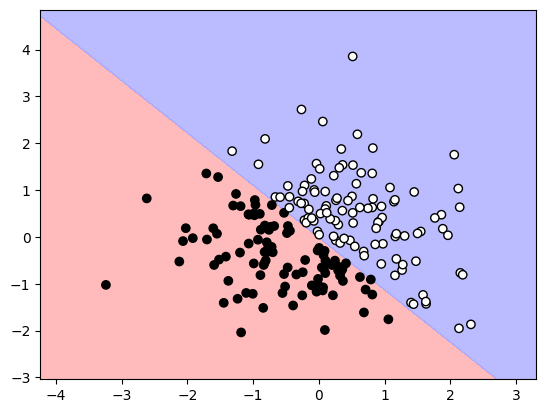

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def visualize_decision_boundary(classifier, features, labels):
    x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    predictions = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    predictions = predictions.reshape(xx.shape)
    plt.contourf(xx, yy, predictions, alpha=0.8, cmap=ListedColormap(('#FFAAAA', '#AAAAFF')))
    plt.scatter(features[:, 0], features[:, 1], c=labels, edgecolors='k', cmap=ListedColormap(('black', 'white')))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
from sklearn.linear_model import LogisticRegression
data = np.random.randn(200, 2)
targets = (data[:, 0] + data[:, 1] > 0).astype(int)
classifier_model = LogisticRegression()
classifier_model.fit(data, targets)
visualize_decision_boundary(classifier_model, data, targets)


#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

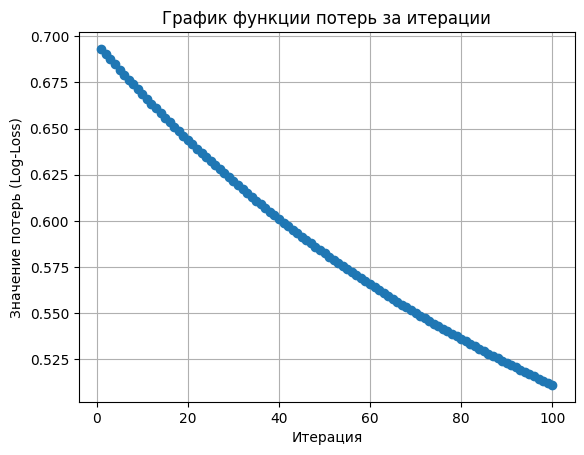

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
def visualize_loss_curve(classifier, features, labels, num_iterations=100, step_size=0.01):
    n_samples, n_features = features.shape
    weights = np.zeros(n_features)
    bias = 0
    loss_record = []
    def sigmoid_function(z):
        return 1 / (1 + np.exp(-z))
    for iteration in range(num_iterations):
        linear_combination = np.dot(features, weights) + bias
        predictions = sigmoid_function(linear_combination)
        loss = -np.mean(labels * np.log(predictions + 1e-15) + (1 - labels) * np.log(1 - predictions + 1e-15))
        loss_record.append(loss)
        weight_gradient = np.dot(features.T, (predictions - labels)) / n_samples
        bias_gradient = np.sum(predictions - labels) / n_samples
        weights -= step_size * weight_gradient
        bias -= step_size * bias_gradient
    plt.plot(range(1, num_iterations + 1), loss_record, marker='o')
    plt.xlabel('Итерация')
    plt.ylabel('Значение потерь (Log-Loss)')
    plt.title('График функции потерь за итерации')
    plt.grid(True)
    plt.show()
from sklearn.datasets import make_classification
features, labels = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=42)
classifier_model = LogisticRegression()
visualize_loss_curve(classifier_model, features, labels)



In [ ]:
plot_loss_history(model)

TypeError: plot_loss_history() missing 2 required positional arguments: 'X' and 'y'

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).


Обучение SVC с kernel='linear' и C=0.1
Accuracy: 0.90
Precision: 0.99
Recall: 0.81
F1-Score: 0.89
AUC-ROC: 0.92


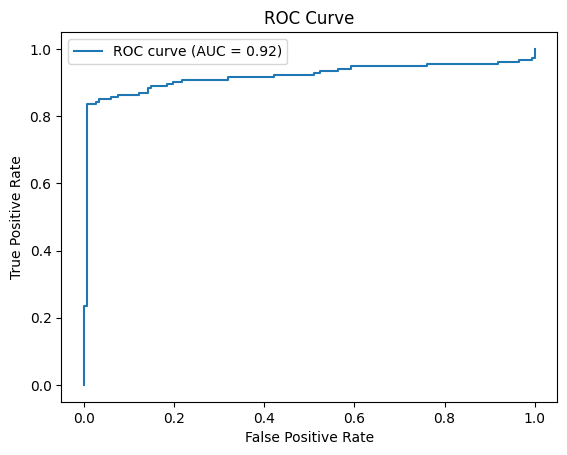


Обучение SVC с kernel='linear' и C=1
Accuracy: 0.91
Precision: 0.99
Recall: 0.84
F1-Score: 0.91
AUC-ROC: 0.92


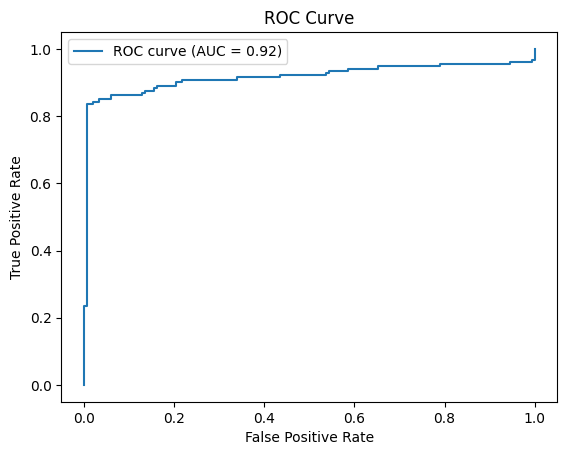


Обучение SVC с kernel='linear' и C=10
Accuracy: 0.91
Precision: 0.99
Recall: 0.84
F1-Score: 0.91
AUC-ROC: 0.92


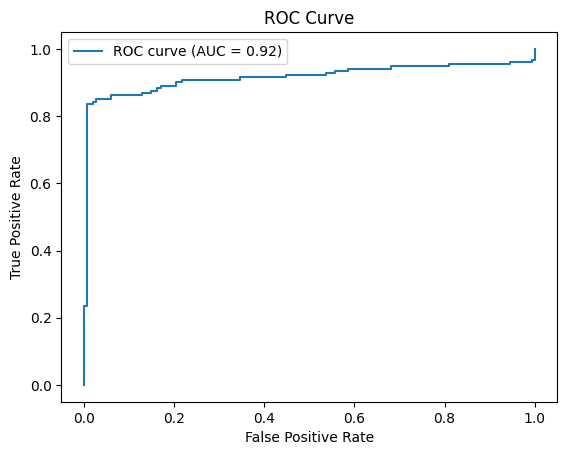


Обучение SVC с kernel='rbf' и C=0.1
Accuracy: 0.90
Precision: 0.99
Recall: 0.81
F1-Score: 0.89
AUC-ROC: 0.94


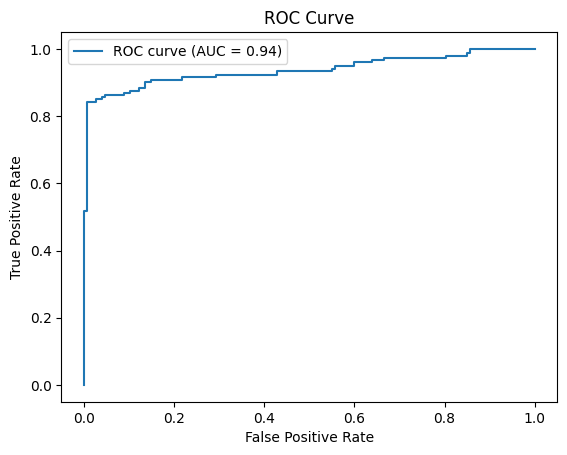


Обучение SVC с kernel='rbf' и C=1
Accuracy: 0.92
Precision: 0.99
Recall: 0.84
F1-Score: 0.91
AUC-ROC: 0.97


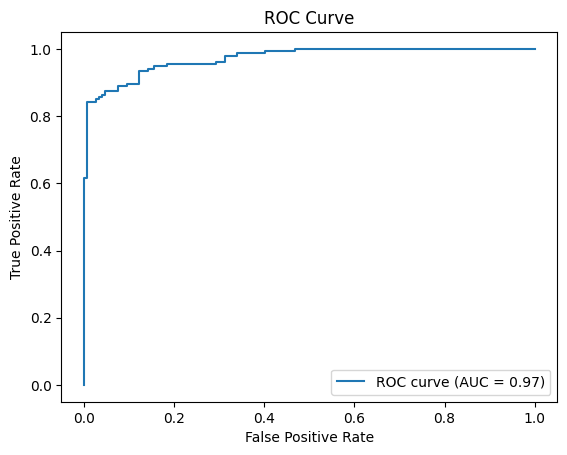


Обучение SVC с kernel='rbf' и C=10
Accuracy: 0.93
Precision: 0.97
Recall: 0.88
F1-Score: 0.92
AUC-ROC: 0.98


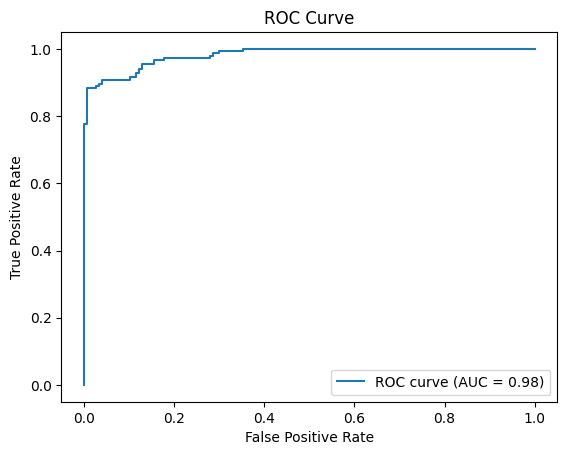


Обучение SVC с kernel='poly' и C=0.1
Accuracy: 0.90
Precision: 0.98
Recall: 0.81
F1-Score: 0.89
AUC-ROC: 0.89


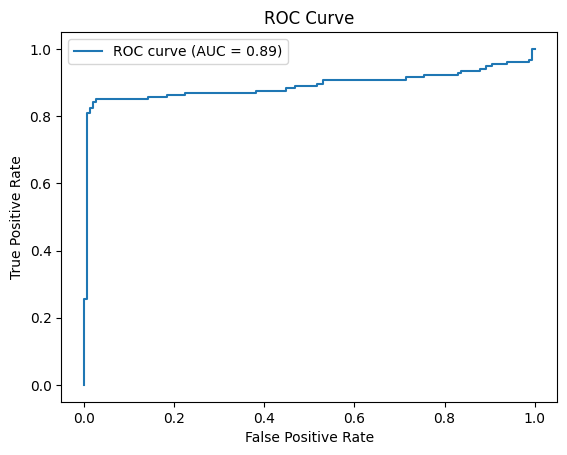


Обучение SVC с kernel='poly' и C=1
Accuracy: 0.90
Precision: 0.95
Recall: 0.85
F1-Score: 0.90
AUC-ROC: 0.91


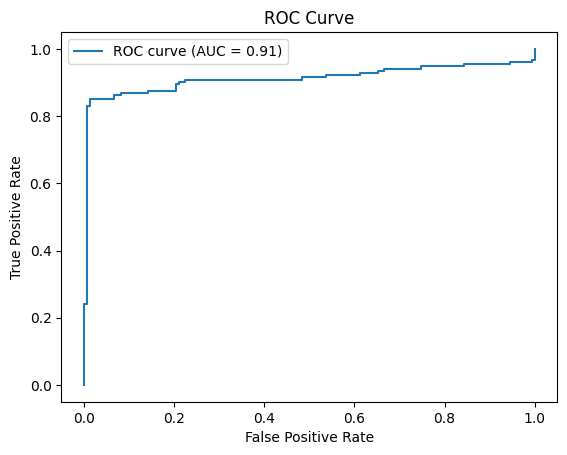


Обучение SVC с kernel='poly' и C=10
Accuracy: 0.90
Precision: 0.95
Recall: 0.86
F1-Score: 0.90
AUC-ROC: 0.93


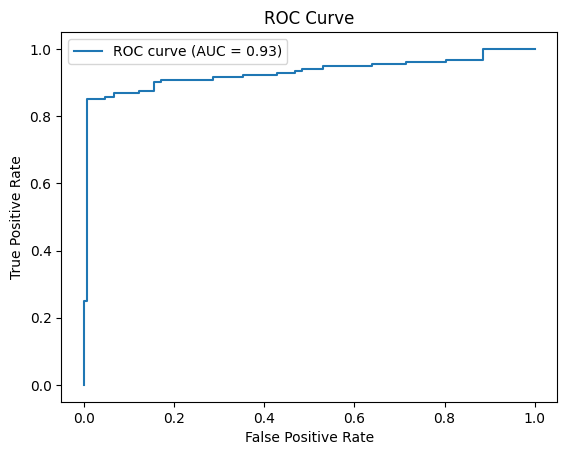

In [8]:
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
features, labels = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                                      random_state=42, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
def assess_model_performance(model, X_test, y_test):
    y_predictions = model.predict(X_test)
    y_probabilities = model.decision_function(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_predictions):.2f}")
    print(f"Precision: {precision_score(y_test, y_predictions):.2f}")
    print(f"Recall: {recall_score(y_test, y_predictions):.2f}")
    print(f"F1-Score: {f1_score(y_test, y_predictions):.2f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_probabilities):.2f}")
    fpr, tpr, _ = roc_curve(y_test, y_probabilities)
    plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_probabilities)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
kernel_types = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]
for kernel in kernel_types:
    for C in C_values:
        print(f"\nОбучение SVC с kernel='{kernel}' и C={C}")
        svc_model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        svc_model.fit(X_train, y_train)
        assess_model_performance(svc_model, X_test, y_test)


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

Accuracy: 0.94
Precision: 0.96
Recall: 0.92
F1-Score: 0.94
AUC-ROC: 0.98


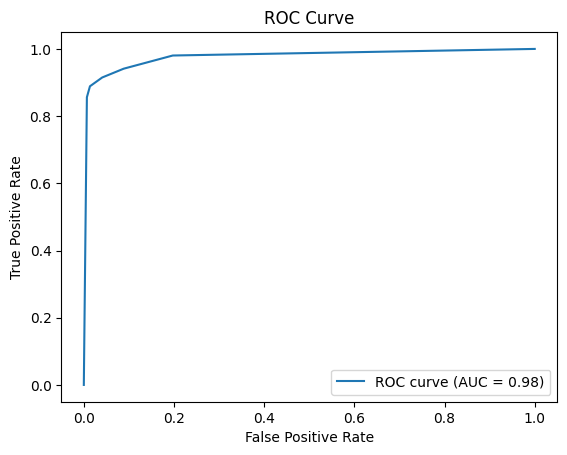

In [9]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
class KNeighborsClassifier:
    def __init__(self, n_neighbors=5, distance_metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.distance_metric = distance_metric
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))
    def predict(self, X):
        predictions = [self._predict_single_instance(instance) for instance in X]
        return np.array(predictions)
    def _predict_single_instance(self, instance):
        distances = [self._euclidean_distance(instance, train_instance) for train_instance in self.X_train]
        nearest_indices = np.argsort(distances)[:self.n_neighbors]
        nearest_labels = [self.y_train[i] for i in nearest_indices]
        most_common_label = Counter(nearest_labels).most_common(1)
        return most_common_label[0][0]
    def predict_proba(self, X):
        probabilities = []
        for instance in X:
            distances = [self._euclidean_distance(instance, train_instance) for train_instance in self.X_train]
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = [self.y_train[i] for i in nearest_indices]
            label_counts = Counter(nearest_labels)
            prob = [label_counts.get(label, 0) / self.n_neighbors for label in np.unique(self.y_train)]
            probabilities.append(prob)
        return np.array(probabilities)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
features, labels = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                                          random_state=42, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
y_proba = knn_model.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_proba)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/train.csv')
print(data.head())

   Id  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
0   0         2         0         0         0         0         0         0   
1   1         9         0         0         0         0         0         0   
2   2         6         0         0         0         0         0         0   
3   3         0         0         0         0         1         2         0   
4   4         3         0         0         0         0         0         0   

   Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  Pixel778  \
0         0         0  ...         0         0         0         0         0   
1         0         0  ...         0         0         0         0         0   
2         0         5  ...         0         0         0        30        43   
3         0         0  ...         3         0         0         0         0   
4         0         0  ...         0         0         0         0         0   

   Pixel779  Pixel780  Pixel781  Pixel782  P

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/drive/MyDrive/train.csv')
print(data.head())
print(data.info())
train_data = data.iloc[:50000]
test_data = data.iloc[50000:]
print(f"Размер обучающей выборки: {train_data.shape}")
print(f"Размер тестовой выборки: {test_data.shape}")


   Id  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
0   0         2         0         0         0         0         0         0   
1   1         9         0         0         0         0         0         0   
2   2         6         0         0         0         0         0         0   
3   3         0         0         0         0         1         2         0   
4   4         3         0         0         0         0         0         0   

   Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  Pixel778  \
0         0         0  ...         0         0         0         0         0   
1         0         0  ...         0         0         0         0         0   
2         0         5  ...         0         0         0        30        43   
3         0         0  ...         3         0         0         0         0   
4         0         0  ...         0         0         0         0         0   

   Pixel779  Pixel780  Pixel781  Pixel782  P

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

Имена столбцов: Index(['Id', 'Category', 'Pixel000', 'Pixel001', 'Pixel002', 'Pixel003',
       'Pixel004', 'Pixel005', 'Pixel006', 'Pixel007',
       ...
       'Pixel774', 'Pixel775', 'Pixel776', 'Pixel777', 'Pixel778', 'Pixel779',
       'Pixel780', 'Pixel781', 'Pixel782', 'Pixel783'],
      dtype='object', length=786)
Форма пиксельных данных: (60000, 784)


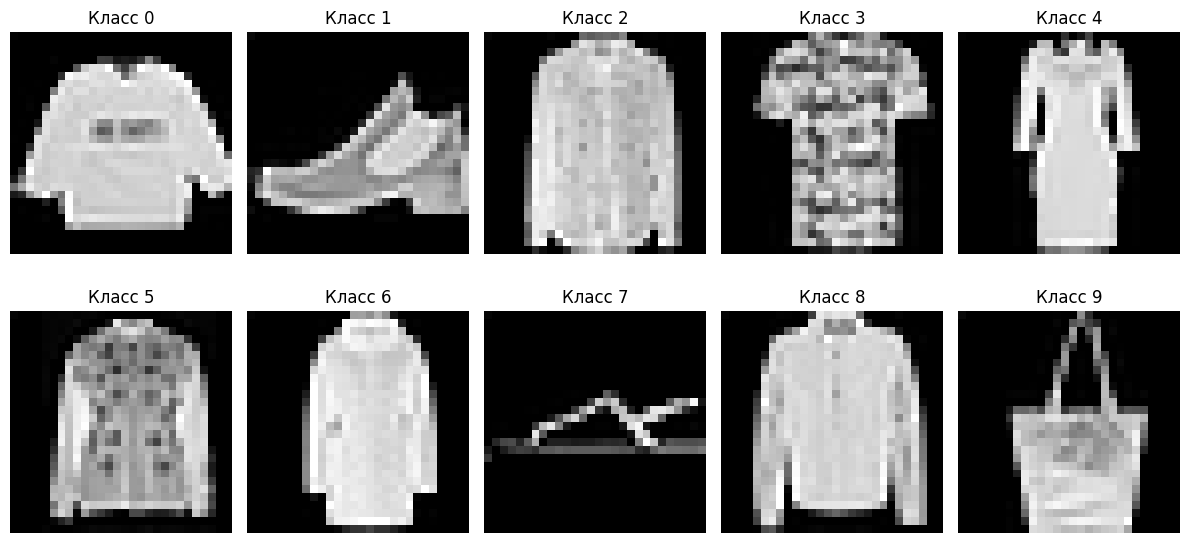

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('/content/drive/MyDrive/train.csv')
print(f"Имена столбцов: {data.columns}")
labels = data.iloc[:, 0]
pixel_data = data.iloc[:, 1:785]
print(f"Форма пиксельных данных: {pixel_data.shape}")
img_dim = 28
num_classes = 10
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(num_classes):
    class_index = labels[labels == i].index[0]
    image_data = pixel_data.iloc[class_index].values.reshape((img_dim, img_dim))
    ax = axes[i // 5, i % 5]
    ax.imshow(image_data, cmap='gray')
    ax.set_title(f"Класс {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()



#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
data = pd.read_csv('/content/drive/MyDrive/train.csv')
labels = data.iloc[:, 0]
pixel_data = data.iloc[:, 1:]
standard_scaler = StandardScaler()
scaled_pixels_standard = standard_scaler.fit_transform(pixel_data)
data_standardized = pd.DataFrame(scaled_pixels_standard, columns=pixel_data.columns)
data_standardized.insert(0, 'label', labels)
minmax_scaler = MinMaxScaler()
scaled_pixels_minmax = minmax_scaler.fit_transform(pixel_data)
data_minmax_scaled = pd.DataFrame(scaled_pixels_minmax, columns=pixel_data.columns)
data_minmax_scaled.insert(0, 'label', labels)
print("Первые строки данных с StandardScaler:")
print(data_standardized.head())
print("\nПервые строки данных с MinMaxScaler:")
print(data_minmax_scaled.head())



Первые строки данных с StandardScaler:
   label  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  \
0      0 -0.870388 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575   
1      1  1.566699 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575   
2      2  0.522233 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575   
3      3 -1.566699 -0.009505 -0.022693 -0.028907  0.366132  0.406799   
4      4 -0.522233 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575   

   Pixel005  Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  \
0 -0.070503 -0.098084 -0.155981  ... -0.601712 -0.476945 -0.395154 -0.406441   
1 -0.070503 -0.098084 -0.155981  ... -0.601712 -0.476945 -0.395154 -0.406441   
2 -0.070503 -0.098084  0.198798  ... -0.601712 -0.476945 -0.395154  0.275910   
3 -0.070503 -0.098084 -0.155981  ... -0.549579 -0.476945 -0.395154 -0.406441   
4 -0.070503 -0.098084 -0.155981  ... -0.601712 -0.476945 -0.395154 -0.406441   

   Pixel778  Pixel779  Pixel780  Pixel781  Pixe

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Ответ: Тут  логистическая регрессия не сможет успешно обучиться, поскольку все объекты обладают одинаковыми характеристиками, что лишает модель информации для различения классов. Из-за отсутствия отличий в признаках модель не сможет сформировать границу для разделения положительного и отрицательного классов. В итоге процесс оптимизации приведет к тому, что для всех объектов будет предсказана одинаковая вероятность, независимо от их классификационной метки. При равномерном распределении классов (50% положительных и 50% отрицательных) модель, вероятнее всего, будет прогнозировать вероятность, близкую к 0.5. Это означает, что предсказания модели будут случайными. В такой ситуации качество классификации окажется низким, и модель станет непригодной для практического использования. Такой результат объясняется отсутствием разнообразия в признаках, которые необходимы для обучения модели.










#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

Имена столбцов: Index(['Id', 'Category', 'Pixel000', 'Pixel001', 'Pixel002', 'Pixel003',
       'Pixel004', 'Pixel005', 'Pixel006', 'Pixel007',
       ...
       'Pixel774', 'Pixel775', 'Pixel776', 'Pixel777', 'Pixel778', 'Pixel779',
       'Pixel780', 'Pixel781', 'Pixel782', 'Pixel783'],
      dtype='object', length=786)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


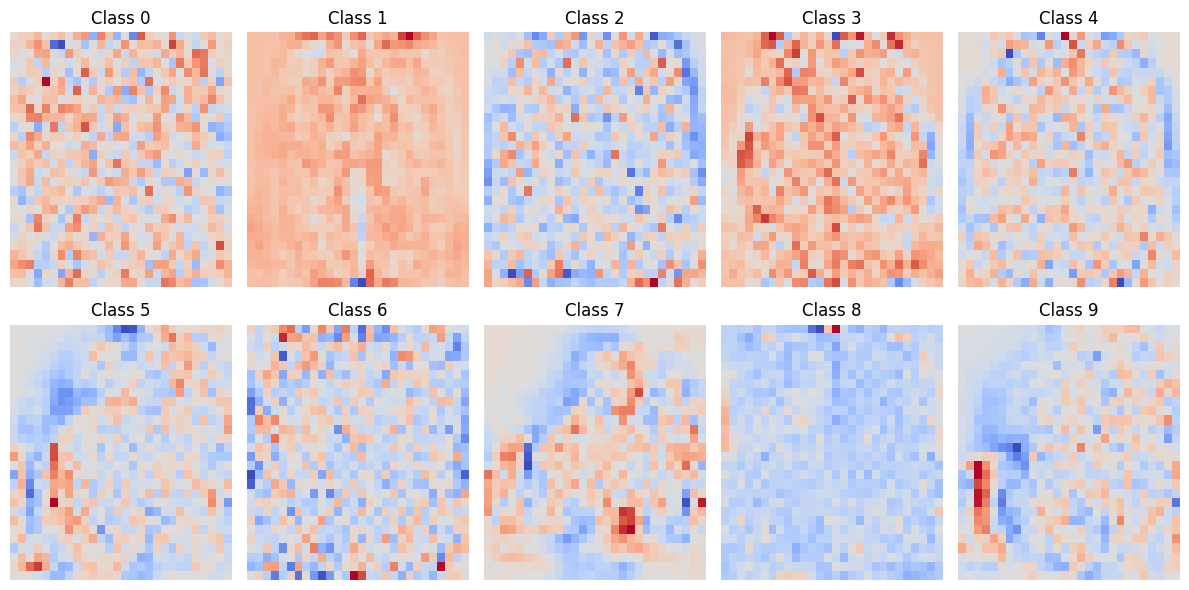

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/drive/MyDrive/train.csv')
print("Имена столбцов:", data.columns)
y = data.iloc[:, 1].values
X = data.iloc[:, 2:].values
num_pixels = X.shape[1]
img_size = int(np.sqrt(num_pixels))
if img_size ** 2 != num_pixels:
    raise ValueError(f"Данные не соответствуют ожидаемому размеру изображения. Ожидается 28x28, получено {num_pixels} пикселей.")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
logistic_reg_model = LogisticRegression(multi_class='ovr', max_iter=1000)
logistic_reg_model.fit(X_scaled, y)
weights = logistic_reg_model.coef_
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    weight_image = weights[i].reshape((img_size, img_size))
    ax = axes[i // 5, i % 5]
    ax.imshow(weight_image, cmap='coolwarm', aspect='auto')
    ax.set_title(f"Class {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()


Пояснение: Логистическая регрессия, несмотря на свою простоту, способна распознавать определенные графические паттерны. Положительные веса указывают на пиксели, которые способствуют отнесению к данному классу, тогда как отрицательные веса обозначают пиксели, которые противодействуют этой классификации.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.